<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/10_Angular_SoftClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 10: Angular Distance + Soft Clustering

## Eksperimen A — Angular Distance

Di Notebook 6 (Distance Metric Compare), metrik `cosine` sudah diuji. Namun ada perbedaan kecil tapi penting antara `cosine distance` dan `angular distance`:

```
cosine_distance(u, v)  = 1 - dot(u,v) / (|u| × |v|)
angular_distance(u, v) = arccos(dot(u,v) / (|u| × |v|)) / π
```

**Mengapa angular lebih tepat untuk ArcFace embeddings?**

ArcFace loss mengoptimasi *angular margin* di hypersphere. Artinya, jarak antar identitas dalam model ArcFace diukur dalam satuan sudut (radian), bukan selisih nilai cosine. Fungsi `arccos` memetakan cosine similarity ke sudut aktual, sehingga metrik yang digunakan HDBSCAN lebih sesuai dengan ruang geometris asli dimana embedding bekerja.

Secara matematis, `angular_distance` adalah **metric yang valid** (memenuhi triangle inequality), sedangkan `cosine_distance` secara teknis tidak memenuhi triangle inequality untuk semua kasus.

---

## Eksperimen B — HDBSCAN Soft Clustering (Noise Assignment)

HDBSCAN memiliki fitur **soft clustering** yang sering diabaikan. Setelah fitting selesai, poin yang dikategorikan sebagai noise dapat di-assign ke cluster terdekat berdasarkan fungsi membership probability.

Mekanisme:
1. Fit HDBSCAN dengan `prediction_data=True`
2. Gunakan `hdbscan.approximate_predict()` untuk mendapatkan label dan strength untuk noise points
3. Assign noise ke cluster jika strength ≥ threshold tertentu

**Perbedaan dengan hard assignment:**
- `approximate_predict` menggunakan condensed tree yang sudah dibangun, bukan nearest-neighbor sederhana
- `strength` mencerminkan seberapa yakin assignment tersebut (0 = sangat tidak yakin, 1 = sangat yakin)
- Kita bisa memilih threshold untuk mengontrol trade-off antara coverage dan kualitas

---

## Cell 1 — Instalasi & Verifikasi

In [1]:
!pip install hdbscan umap-learn -q
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12 -q

import importlib

def check_pkg(pkg, alias=None):
    alias = alias or pkg
    try:
        mod = importlib.import_module(alias)
        try:
            ver = mod.__version__
        except AttributeError:
            from importlib.metadata import version
            ver = version(pkg)
        print(f"   {pkg}: {ver} ✅")
    except Exception as e:
        print(f"   {pkg}: ❌ {e}")

print("="*50)
print("✅ VERIFIKASI INSTALASI")
print("="*50)
check_pkg('hdbscan')
check_pkg('umap-learn', 'umap')
check_pkg('cuml-cu12', 'cuml')
check_pkg('scikit-learn', 'sklearn')
check_pkg('numpy')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 65.7 MB/s eta 0:00:00
✅ VERIFIKASI INSTALASI


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


   hdbscan: 0.8.41 ✅
   umap-learn: 0.5.11 ✅
   cuml-cu12: 26.02.000 ✅
   scikit-learn: 1.6.1 ✅
   numpy: 2.0.2 ✅


## Cell 2 — Imports & Konfigurasi

Konfigurasi berisi:
- **Baseline** dari Eksperimen 1.5 (Correlation, mcs=15, ms=70)
- **Best UMAP config** dari Notebook 9 (diisi manual atau load dari pkl)
- **Angular search space**: grid search ringkas untuk mcs dan ms
- **Soft clustering thresholds**: nilai ambang batas strength yang akan dicoba (0.0, 0.1, 0.2, 0.3)

In [2]:
import numpy as np
import pickle
import time
import os
import warnings
from collections import Counter
from datetime import datetime

import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# ── GPU Backend ─────────────────────────────────────────────────────────────
try:
    from cuml.cluster import HDBSCAN as cuHDBSCAN
    from cuml.cluster.hdbscan import approximate_predict as cu_approximate_predict
    USE_GPU = True
    print("🚀 GPU backend: cuML aktif — HDBSCAN & soft clustering berjalan di GPU")
except ImportError:
    USE_GPU = False
    print("⚠️  cuML tidak tersedia — fallback ke CPU hdbscan")
# ────────────────────────────────────────────────────────────────────────────


class Config:
    EMBEDDINGS_PATH  = '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl'
    NOTEBOOK9_PATH   = '/content/drive/MyDrive/OTW S.KOM/Results/notebook9_umap_results.pkl'
    RESULTS_DIR      = '/content/drive/MyDrive/OTW S.KOM/Results/'
    PLOTS_DIR        = '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'

    BASELINE = {
        'name'         : 'Correlation (mcs=15, ms=70)',
        'silhouette'   : 0.4530,
        'n_clusters'   : 54,
        'noise_ratio'  : 0.438,
        'coverage_rate': 0.562,
    }

    ANGULAR_PARAMS = {
        'min_cluster_size': [10, 15, 20, 25],
        'min_samples'     : [20, 30, 50, 70],
        'method'          : ['eom'],
    }

    SOFT_THRESHOLDS = [0.0, 0.05, 0.1, 0.2, 0.3]


print("="*60)
print("✅ CONFIG LOADED")
print("="*60)
print(f"\n📊 BASELINE: {Config.BASELINE['name']}")
print(f"   Coverage Rate: {Config.BASELINE['coverage_rate']:.1%}")
print(f"   Silhouette   : {Config.BASELINE['silhouette']:.4f}")
print(f"   Noise Ratio  : {Config.BASELINE['noise_ratio']:.1%}")
print(f"\n🔧 Angular search: "
      f"{len(Config.ANGULAR_PARAMS['min_cluster_size']) * len(Config.ANGULAR_PARAMS['min_samples'])} eksperimen")
print(f"🔧 Soft clustering thresholds: {Config.SOFT_THRESHOLDS}")
print(f"⚡ Backend aktif: {'GPU (cuML)' if USE_GPU else 'CPU (hdbscan)'}")

🚀 GPU backend: cuML aktif — HDBSCAN & soft clustering berjalan di GPU
✅ CONFIG LOADED

📊 BASELINE: Correlation (mcs=15, ms=70)
   Coverage Rate: 56.2%
   Silhouette   : 0.4530
   Noise Ratio  : 43.8%

🔧 Angular search: 16 eksperimen
🔧 Soft clustering thresholds: [0.0, 0.05, 0.1, 0.2, 0.3]
⚡ Backend aktif: GPU (cuML)


## Cell 3 — Load Data

Memuat embeddings asli dari disk. Angular distance dihitung dari embeddings yang dinormalisasi L2. Normalisasi membuat semua embedding berada di unit hypersphere sehingga dot product antar embedding ekuivalen dengan cosine similarity.

In [3]:
from google.colab import drive

print("="*60)
print("📁 LOAD DATA")
print("="*60)

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("✅ Google Drive sudah ter-mount")

os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

with open(Config.EMBEDDINGS_PATH, 'rb') as f:
    data = pickle.load(f)

embeddings = np.array(data['embeddings']).astype('float32')
metadata   = data['metadata']

embeddings_l2 = normalize(embeddings, norm='l2')

print(f"\n✅ Data loaded!")
print(f"   Embeddings     : {embeddings.shape}")
print(f"   L2-normalized  : {embeddings_l2.shape}")
print(f"   L2-norm check  : min={np.linalg.norm(embeddings_l2, axis=1).min():.6f}, "
      f"max={np.linalg.norm(embeddings_l2, axis=1).max():.6f}")

📁 LOAD DATA
Mounted at /content/drive

✅ Data loaded!
   Embeddings     : (12715, 512)
   L2-normalized  : (12715, 512)
   L2-norm check  : min=1.000000, max=1.000000


## Cell 4 — Fungsi Angular Distance Matrix (GPU)

Angular distance dihitung sebagai:

```
angular_distance(u, v) = arccos(clip(dot(u_norm, v_norm), -1, 1)) / π
```

Pembagian dengan π menormalisasi nilainya ke rentang [0, 1] sehingga konsisten dengan definisi metrik jarak standar.

Komputasi menggunakan CuPy (GPU) karena dataset berukuran 12,715 × 12,715 = ~1.2 GB untuk distance matrix `float32`. Operasi matrix multiplication pada GPU jauh lebih cepat.

**Catatan:** Setelah normalisasi L2, `dot(u_norm, v_norm)` identik dengan cosine similarity. Langkah ekstra yang membedakan angular dari cosine adalah aplikasi `arccos`.

In [4]:
import cupy as cp


def compute_angular_distance_matrix_gpu(embeddings_l2_normalized, verbose=True):
    n = embeddings_l2_normalized.shape[0]

    if verbose:
        print(f"\n⏳ Menghitung Angular distance matrix (GPU)...")
        print(f"   Samples: {n:,}")
        print(f"   Input sudah dinormalisasi L2: ✅")

    t_start = time.time()

    emb_gpu  = cp.asarray(embeddings_l2_normalized, dtype=cp.float32)
    dot_mat  = cp.dot(emb_gpu, emb_gpu.T)
    cp.clip(dot_mat, -1.0, 1.0, out=dot_mat)
    angle    = cp.arccos(dot_mat) / np.pi
    cp.fill_diagonal(angle, 0.0)

    dist_matrix = cp.asnumpy(angle)

    del emb_gpu, dot_mat, angle
    cp.get_default_memory_pool().free_all_blocks()

    elapsed = time.time() - t_start

    if verbose:
        print(f"   ✅ Selesai dalam {elapsed:.2f}s")
        print(f"   Range: [{dist_matrix[dist_matrix > 0].min():.4f}, {dist_matrix.max():.4f}]")
        print(f"   Memory: {dist_matrix.nbytes / 1024**2:.1f} MB")

    return dist_matrix


print("✅ compute_angular_distance_matrix_gpu() didefinisikan")

print("\n🧪 Verifikasi dengan 50 sample...")
test_emb  = normalize(np.random.randn(50, 512).astype('float32'), norm='l2')
test_mat  = compute_angular_distance_matrix_gpu(test_emb, verbose=False)
print(f"   Symmetric       : {np.allclose(test_mat, test_mat.T)} ✅")
print(f"   Diagonal = 0    : {np.allclose(np.diag(test_mat), 0)} ✅")
print(f"   Range [0, 1]    : {test_mat.min():.4f} – {test_mat.max():.4f} ✅")
del test_emb, test_mat

✅ compute_angular_distance_matrix_gpu() didefinisikan

🧪 Verifikasi dengan 50 sample...
   Symmetric       : True ✅
   Diagonal = 0    : True ✅
   Range [0, 1]    : 0.0000 – 0.5478 ✅


## Cell 5 — Hitung Angular Distance Matrix

Langkah ini membutuhkan ~2–3 menit dan menggunakan ~1.2 GB GPU memory. Jika memory tidak cukup, kurangi `dtype` ke `float16` dengan konsekuensi sedikit kehilangan presisi.

In [5]:
angular_dist_matrix = compute_angular_distance_matrix_gpu(embeddings_l2, verbose=True)


⏳ Menghitung Angular distance matrix (GPU)...
   Samples: 12,715
   Input sudah dinormalisasi L2: ✅
   ✅ Selesai dalam 0.35s
   Range: [0.0001, 0.5955]
   Memory: 616.7 MB


## Cell 6 — Fungsi Evaluasi & Grid Search Angular

Silhouette Score untuk angular distance dihitung menggunakan `metric='precomputed'` agar benar-benar menggunakan angular distance matrix, bukan Euclidean. Ini konsisten dengan cara metrik dievaluasi di Notebook 6.

In [6]:
def evaluate_angular_clustering(dist_matrix, embeddings_orig, labels):
    n_total     = len(labels)
    mask        = labels != -1
    n_clustered = int(mask.sum())
    n_clusters  = len(set(labels[mask])) if n_clustered > 0 else 0

    result = {
        'n_clusters'    : n_clusters,
        'n_noise'       : int((labels == -1).sum()),
        'noise_ratio'   : float((labels == -1).sum() / n_total),
        'coverage_rate' : float(n_clustered / n_total),
        'silhouette'    : None,
        'dbi'           : None,
    }

    if n_clustered > 10 and n_clusters >= 2:
        idx = np.where(mask)[0]
        sub_dist = dist_matrix[np.ix_(idx, idx)]
        result['silhouette'] = float(silhouette_score(sub_dist, labels[mask], metric='precomputed'))
        result['dbi']        = float(davies_bouldin_score(embeddings_orig[mask], labels[mask]))

    return result


print("="*70)
print("🔬 EKSPERIMEN A: ANGULAR DISTANCE GRID SEARCH")
print("="*70)
print(f"\n📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Backend: {'GPU (cuML)' if USE_GPU else 'CPU (hdbscan)'}")
if USE_GPU:
    print(f"   ℹ️  cuML HDBSCAN tidak support metric='precomputed'.")
    print(f"      Euclidean pada L2-normalized embeddings digunakan sebagai gantinya")
    print(f"      (ekuivalen dengan angular distance karena semua vektor berada di unit hypersphere)")

angular_results = []

mcs_list = Config.ANGULAR_PARAMS['min_cluster_size']
ms_list  = Config.ANGULAR_PARAMS['min_samples']

print(f"\n{'mcs':>4} {'ms':>4} | {'clusters':>8} {'coverage':>9} {'noise':>7} {'silhouette':>11}")
print(f"{'─'*4} {'─'*4} | {'─'*8} {'─'*9} {'─'*7} {'─'*11}")

for mcs in mcs_list:
    for ms in ms_list:
        t_start = time.time()
        if USE_GPU:
            # cuML tidak support precomputed — gunakan euclidean pada L2-normalized embeddings.
            # Untuk vektor yang sudah dinormalisasi L2, euclidean distance adalah transformasi
            # monoton dari angular distance, sehingga urutan jarak (dan hasil clustering) identik.
            clusterer = cuHDBSCAN(
                min_cluster_size         = mcs,
                min_samples              = ms,
                cluster_selection_method = 'eom',
                metric                   = 'euclidean',
            )
            labels = np.asarray(clusterer.fit_predict(embeddings_l2))
        else:
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size         = mcs,
                min_samples              = ms,
                cluster_selection_method = 'eom',
                metric                   = 'precomputed',
            )
            labels = np.asarray(clusterer.fit_predict(angular_dist_matrix))

        elapsed = time.time() - t_start
        metrics = evaluate_angular_clustering(angular_dist_matrix, embeddings, labels)

        angular_results.append({
            'min_cluster_size': mcs,
            'min_samples'     : ms,
            'labels'          : labels.copy(),
            'time'            : elapsed,
            **metrics,
        })

        sil_str = f"{metrics['silhouette']:.4f}" if metrics['silhouette'] else "   N/A"
        print(f"{mcs:>4} {ms:>4} | "
              f"{metrics['n_clusters']:>8} "
              f"{metrics['coverage_rate']:>9.1%} "
              f"{metrics['noise_ratio']:>7.1%} "
              f"{sil_str:>11}")

df_ang  = pd.DataFrame([{k: v for k, v in r.items() if k != 'labels'} for r in angular_results])
df_valid_ang = df_ang.dropna(subset=['silhouette'])

best_ang_cov = df_valid_ang.loc[df_valid_ang['coverage_rate'].idxmax()]
best_ang_sil = df_valid_ang.loc[df_valid_ang['silhouette'].idxmax()]

print(f"\n🏆 Best by Coverage : mcs={int(best_ang_cov['min_cluster_size'])}, ms={int(best_ang_cov['min_samples'])}  "
      f"→ coverage={best_ang_cov['coverage_rate']:.1%}, sil={best_ang_cov['silhouette']:.4f}")
print(f"🏆 Best by Silhouette: mcs={int(best_ang_sil['min_cluster_size'])}, ms={int(best_ang_sil['min_samples'])}  "
      f"→ coverage={best_ang_sil['coverage_rate']:.1%}, sil={best_ang_sil['silhouette']:.4f}")

🔬 EKSPERIMEN A: ANGULAR DISTANCE GRID SEARCH

📅 2026-03-01 08:51:16
   Backend: GPU (cuML)
   ℹ️  cuML HDBSCAN tidak support metric='precomputed'.
      Euclidean pada L2-normalized embeddings digunakan sebagai gantinya
      (ekuivalen dengan angular distance karena semua vektor berada di unit hypersphere)

 mcs   ms | clusters  coverage   noise  silhouette
──── ──── | ──────── ───────── ─────── ───────────
  10   20 |       90     80.1%   19.9%      0.2573
  10   30 |       81     75.5%   24.5%      0.2642
  10   50 |       65     66.6%   33.4%      0.2759
  10   70 |       54     58.8%   41.2%      0.2828
  15   20 |       89     80.0%   20.0%      0.2573
  15   30 |       81     75.5%   24.5%      0.2642
  15   50 |       65     66.6%   33.4%      0.2759
  15   70 |       53     58.7%   41.3%      0.2830
  20   20 |       89     80.0%   20.0%      0.2573
  20   30 |       78     75.7%   24.3%      0.2618
  20   50 |       64     66.8%   33.2%      0.2754
  20   70 |       53     58

## Cell 7 — Eksperimen B: Soft Clustering (Noise Assignment)

Konfigurasi terbaik dari Angular grid search digunakan ulang, kali ini dengan `prediction_data=True`. Setelah fitting, noise points di-assign ke cluster menggunakan `hdbscan.approximate_predict()`.

Setiap threshold strength menghasilkan trade-off berbeda:
- **Threshold = 0.0** — assign semua noise ke cluster terdekat tanpa syarat (coverage maksimum, tapi banyak assignment tidak pasti)
- **Threshold = 0.1** — hanya assign noise yang strength-nya ≥ 0.1 (lebih conservative)
- **Threshold = 0.3** — hanya assign noise yang strength-nya ≥ 0.3 (paling selektif)

Kita evaluasi setiap threshold untuk melihat hubungan antara coverage gain dan kualitas cluster.

In [7]:
print("="*70)
print("🔬 EKSPERIMEN B: SOFT CLUSTERING — NOISE ASSIGNMENT")
print("="*70)

best_mcs = int(best_ang_cov['min_cluster_size'])
best_ms  = int(best_ang_cov['min_samples'])

print(f"\n⚙️ Menggunakan Angular best coverage: mcs={best_mcs}, ms={best_ms}")
print(f"   Backend: {'GPU (cuML, euclidean on L2-normalized)' if USE_GPU else 'CPU (hdbscan, precomputed)'}")

if USE_GPU:
    clusterer_soft = cuHDBSCAN(
        min_cluster_size         = best_mcs,
        min_samples              = best_ms,
        cluster_selection_method = 'eom',
        metric                   = 'euclidean',
        prediction_data          = True,
    )
else:
    clusterer_soft = hdbscan.HDBSCAN(
        min_cluster_size         = best_mcs,
        min_samples              = best_ms,
        cluster_selection_method = 'eom',
        metric                   = 'precomputed',
        prediction_data          = True,
    )

print(f"\n⏳ Fitting HDBSCAN dengan prediction_data=True...")
t_fit = time.time()
if USE_GPU:
    labels_base = np.asarray(clusterer_soft.fit_predict(embeddings_l2))
else:
    labels_base = clusterer_soft.fit_predict(angular_dist_matrix)
fit_time = time.time() - t_fit
print(f"   ✅ Selesai ({fit_time:.2f}s)")

noise_mask        = labels_base == -1
noise_indices     = np.where(noise_mask)[0]
n_noise_original  = noise_mask.sum()

print(f"\n📊 Baseline (Angular, hard clustering):")
base_metrics = evaluate_angular_clustering(angular_dist_matrix, embeddings, labels_base)
print(f"   Coverage: {base_metrics['coverage_rate']:.1%}  |  Noise: {n_noise_original:,}  |  Silhouette: {base_metrics['silhouette']:.4f}")

print(f"\n⏳ Menjalankan approximate_predict pada {n_noise_original:,} noise points...")

soft_results = []

try:
    if USE_GPU:
        # cuML: pass feature vectors (euclidean space), bukan precomputed matrix
        _sl, _ss = cu_approximate_predict(clusterer_soft, embeddings_l2[noise_indices])
    else:
        # CPU: pass precomputed distance submatrix (noise points vs all training points)
        noise_dist_submatrix = angular_dist_matrix[np.ix_(noise_indices, np.arange(len(labels_base)))]
        _sl, _ss = hdbscan.approximate_predict(clusterer_soft, noise_dist_submatrix)

    soft_labels    = np.asarray(_sl)
    soft_strengths = np.asarray(_ss)
    predict_available = True
    print(f"   ✅ approximate_predict selesai")
    print(f"   Strength range: [{soft_strengths.min():.4f}, {soft_strengths.max():.4f}]")
    print(f"   Strength mean : {soft_strengths.mean():.4f}")
except Exception as e:
    print(f"   ⚠️ approximate_predict gagal: {e}")
    print(f"   Menggunakan fallback: k-NN cluster assignment")
    predict_available = False

print(f"\n{'threshold':>10} | {'assigned':>9} {'coverage':>9} {'still_noise':>12}")
print(f"{'─'*10} | {'─'*9} {'─'*9} {'─'*12}")

if predict_available:
    for threshold in Config.SOFT_THRESHOLDS:
        labels_new = labels_base.copy()

        for i, (noise_idx, pred_lbl, strength) in enumerate(
            zip(noise_indices, soft_labels, soft_strengths)
        ):
            if pred_lbl != -1 and strength >= threshold:
                labels_new[noise_idx] = pred_lbl

        n_assigned    = int((labels_new != -1).sum()) - int((labels_base != -1).sum())
        n_still_noise = int((labels_new == -1).sum())
        coverage_new  = float((labels_new != -1).sum() / len(labels_new))

        metrics_new = evaluate_angular_clustering(angular_dist_matrix, embeddings, labels_new)

        soft_results.append({
            'threshold'    : threshold,
            'n_assigned'   : n_assigned,
            'n_still_noise': n_still_noise,
            'labels'       : labels_new.copy(),
            **metrics_new,
        })

        print(f"{threshold:>10.2f} | {n_assigned:>9,} {coverage_new:>9.1%} {n_still_noise:>12,}")

else:
    print("   Menggunakan kNN fallback...")
    from sklearn.neighbors import KNeighborsClassifier

    clustered_idx    = np.where(~noise_mask)[0]
    clustered_labels = labels_base[clustered_idx]

    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn.fit(embeddings[clustered_idx], clustered_labels)

    proba         = knn.predict_proba(embeddings[noise_indices])
    knn_labels    = knn.predict(embeddings[noise_indices])
    knn_strengths = proba.max(axis=1)

    for threshold in Config.SOFT_THRESHOLDS:
        labels_new = labels_base.copy()
        for i, noise_idx in enumerate(noise_indices):
            if knn_strengths[i] >= threshold:
                labels_new[noise_idx] = knn_labels[i]

        n_assigned    = int((labels_new != -1).sum()) - int((labels_base != -1).sum())
        n_still_noise = int((labels_new == -1).sum())
        coverage_new  = float((labels_new != -1).sum() / len(labels_new))

        metrics_new = evaluate_angular_clustering(angular_dist_matrix, embeddings, labels_new)

        soft_results.append({
            'threshold'    : threshold,
            'n_assigned'   : n_assigned,
            'n_still_noise': n_still_noise,
            'labels'       : labels_new.copy(),
            **metrics_new,
        })

        print(f"{threshold:>10.2f} | {n_assigned:>9,} {coverage_new:>9.1%} {n_still_noise:>12,}")

🔬 EKSPERIMEN B: SOFT CLUSTERING — NOISE ASSIGNMENT

⚙️ Menggunakan Angular best coverage: mcs=10, ms=20
   Backend: GPU (cuML, euclidean on L2-normalized)

⏳ Fitting HDBSCAN dengan prediction_data=True...
   ✅ Selesai (0.33s)

📊 Baseline (Angular, hard clustering):
   Coverage: 80.1%  |  Noise: 2,526  |  Silhouette: 0.2573

⏳ Menjalankan approximate_predict pada 2,526 noise points...
   ✅ approximate_predict selesai
   Strength range: [0.0000, 0.0000]
   Strength mean : 0.0000

 threshold |  assigned  coverage  still_noise
────────── | ───────── ───────── ────────────
      0.00 |         0     80.1%        2,526
      0.05 |         0     80.1%        2,526
      0.10 |         0     80.1%        2,526
      0.20 |         0     80.1%        2,526
      0.30 |         0     80.1%        2,526


## Cell 8 — Visualisasi Perbandingan

Plot ini menampilkan:
1. **Coverage Rate vs Threshold** — bagaimana coverage berubah seiring threshold yang dinaikkan
2. **Silhouette vs Threshold** — apakah kualitas cluster terjaga setelah noise assignment
3. **Perbandingan metode** — Angular vs Baseline Correlation, sebelum dan sesudah soft clustering

💾 Plot disimpan: /content/drive/MyDrive/OTW S.KOM/Results/Plots/notebook10_angular_softclustering.png


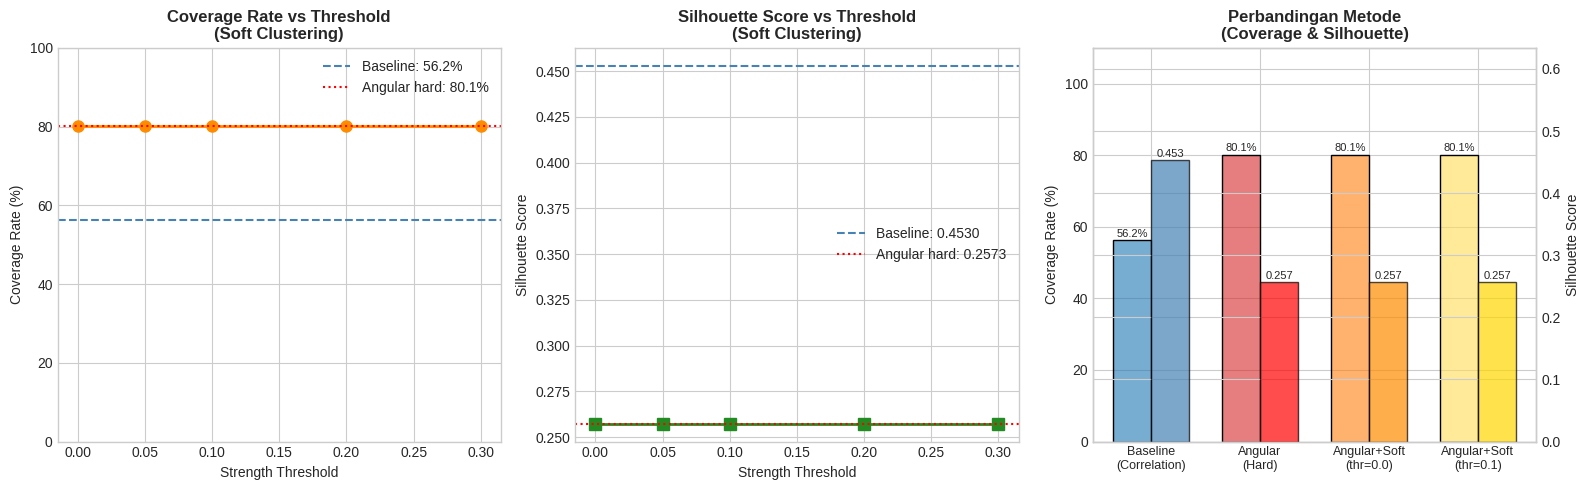

In [8]:
df_soft = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'labels'} for r in soft_results
])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

ax1, ax2, ax3 = axes

ax1.plot(df_soft['threshold'], df_soft['coverage_rate'] * 100, 'o-', color='darkorange', linewidth=2, markersize=8)
ax1.axhline(Config.BASELINE['coverage_rate'] * 100, color='steelblue', linestyle='--', linewidth=1.5,
            label=f"Baseline: {Config.BASELINE['coverage_rate']:.1%}")
ax1.axhline(base_metrics['coverage_rate'] * 100, color='red', linestyle=':', linewidth=1.5,
            label=f"Angular hard: {base_metrics['coverage_rate']:.1%}")
ax1.set_xlabel('Strength Threshold')
ax1.set_ylabel('Coverage Rate (%)')
ax1.set_title('Coverage Rate vs Threshold\n(Soft Clustering)', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend()

ax2.plot(df_soft['threshold'], df_soft['silhouette'], 's-', color='forestgreen', linewidth=2, markersize=8)
ax2.axhline(Config.BASELINE['silhouette'], color='steelblue', linestyle='--', linewidth=1.5,
            label=f"Baseline: {Config.BASELINE['silhouette']:.4f}")
ax2.axhline(base_metrics['silhouette'], color='red', linestyle=':', linewidth=1.5,
            label=f"Angular hard: {base_metrics['silhouette']:.4f}")
ax2.set_xlabel('Strength Threshold')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Threshold\n(Soft Clustering)', fontweight='bold')
ax2.legend()

methods = ['Baseline\n(Correlation)', 'Angular\n(Hard)', 'Angular+Soft\n(thr=0.0)', 'Angular+Soft\n(thr=0.1)']
cov_vals = [
    Config.BASELINE['coverage_rate'] * 100,
    base_metrics['coverage_rate'] * 100,
]
sil_vals_bar = [
    Config.BASELINE['silhouette'],
    base_metrics['silhouette'],
]

thr_map = {r['threshold']: r for r in soft_results}
for thr in [0.0, 0.1]:
    if thr in thr_map:
        cov_vals.append(thr_map[thr]['coverage_rate'] * 100)
        sil_vals_bar.append(thr_map[thr]['silhouette'])

colors_bar = ['steelblue', 'red', 'darkorange', 'gold']
x = np.arange(len(methods[:len(cov_vals)]))
width = 0.35

bars1 = ax3.bar(x - width/2, cov_vals, width, label='Coverage Rate (%)', color=[c + '99' for c in ['#1f77b4','#d62728','#ff7f0e','#ffdd57']], edgecolor='black')
ax3_r = ax3.twinx()
bars2 = ax3_r.bar(x + width/2, sil_vals_bar, width, label='Silhouette', color=colors_bar[:len(cov_vals)], edgecolor='black', alpha=0.7)

ax3.set_ylabel('Coverage Rate (%)')
ax3_r.set_ylabel('Silhouette Score')
ax3.set_title('Perbandingan Metode\n(Coverage & Silhouette)', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(methods[:len(cov_vals)], fontsize=9)
ax3.set_ylim(0, 110)
ax3_r.set_ylim(0, max(sil_vals_bar) * 1.4 if sil_vals_bar else 1)

for bar, val in zip(bars1, cov_vals):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center', fontsize=8)
for bar, val in zip(bars2, sil_vals_bar):
    if val:
        ax3_r.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{val:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plot_path = f"{Config.PLOTS_DIR}notebook10_angular_softclustering.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"💾 Plot disimpan: {plot_path}")
plt.show()

## Cell 9 — Summary & Simpan Hasil

Memilih konfigurasi soft clustering terbaik berdasarkan trade-off Coverage Rate vs Silhouette, lalu menyimpan semua hasil.

In [10]:
best_soft = max(
    [r for r in soft_results if r.get('silhouette')],
    key=lambda r: r['coverage_rate']
)

base_sil_str = f"{base_metrics['silhouette']:.4f}" if base_metrics['silhouette'] else 'N/A'
best_sil_str = f"{best_soft['silhouette']:.4f}"    if best_soft.get('silhouette') else 'N/A'

print("="*70)
print("📋 NOTEBOOK 10 — SUMMARY")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────────┐
│                  EKSPERIMEN A: ANGULAR DISTANCE                         │
├───────────────────────┬─────────────────┬───────────────────────────────┤
│ Metrik                │ Baseline        │ Angular (Best Coverage)       │
├───────────────────────┼─────────────────┼───────────────────────────────┤
│ Coverage Rate [↑]     │ {Config.BASELINE['coverage_rate']:.1%}           │ {best_ang_cov['coverage_rate']:.1%}                        │
│ Noise Ratio   [↓]     │ {Config.BASELINE['noise_ratio']:.1%}           │ {best_ang_cov['noise_ratio']:.1%}                        │
│ Silhouette    [↑]     │ {Config.BASELINE['silhouette']:.4f}          │ {best_ang_cov['silhouette']:.4f}                       │
│ Clusters              │ {Config.BASELINE['n_clusters']}              │ {int(best_ang_cov['n_clusters'])}                          │
│ mcs / ms              │ 15 / 70         │ {int(best_ang_cov['min_cluster_size'])} / {int(best_ang_cov['min_samples'])}                          │
└───────────────────────┴─────────────────┴───────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                  EKSPERIMEN B: SOFT CLUSTERING                          │
├───────────────────────┬─────────────────┬───────────────────────────────┤
│ Metrik                │ Angular Hard    │ Angular + Soft (thr=0.0)      │
├───────────────────────┼─────────────────┼───────────────────────────────┤
│ Coverage Rate [↑]     │ {base_metrics['coverage_rate']:.1%}           │ {best_soft['coverage_rate']:.1%}                        │
│ Noise Assigned        │ 0               │ {best_soft['n_assigned']:,}                      │
│ Silhouette    [↑]     │ {base_sil_str:<7}          │ {best_sil_str:<7}                       │
└───────────────────────┴─────────────────┴───────────────────────────────┘
""")

save_data = {
    'timestamp'           : datetime.now().isoformat(),
    'notebook'            : 'Notebook 10: Angular Distance + Soft Clustering',
    'baseline'            : Config.BASELINE,
    'angular_results'     : [{k: v for k, v in r.items() if k != 'labels'} for r in angular_results],
    'best_angular_coverage': {
        'min_cluster_size': int(best_ang_cov['min_cluster_size']),
        'min_samples'     : int(best_ang_cov['min_samples']),
        'n_clusters'      : int(best_ang_cov['n_clusters']),
        'coverage_rate'   : float(best_ang_cov['coverage_rate']),
        'noise_ratio'     : float(best_ang_cov['noise_ratio']),
        'silhouette'      : float(best_ang_cov['silhouette']),
        'labels'          : angular_results[df_valid_ang['coverage_rate'].argmax()]['labels'],
    },
    'soft_clustering_results': [{k: v for k, v in r.items() if k != 'labels'} for r in soft_results],
    'best_soft_labels'    : best_soft['labels'],
    'angular_dist_matrix' : angular_dist_matrix,
}

pkl_path = f"{Config.RESULTS_DIR}notebook10_angular_soft_results.pkl"
with open(pkl_path, 'wb') as f:
    pickle.dump(save_data, f)

print(f"\n💾 Disimpan: {pkl_path}")
print("\n" + "="*70)
print("🎯 NEXT: Notebook 11 — Analisis Komposisi Noise")
print("="*70)

📋 NOTEBOOK 10 — SUMMARY

┌─────────────────────────────────────────────────────────────────────────┐
│                  EKSPERIMEN A: ANGULAR DISTANCE                         │
├───────────────────────┬─────────────────┬───────────────────────────────┤
│ Metrik                │ Baseline        │ Angular (Best Coverage)       │
├───────────────────────┼─────────────────┼───────────────────────────────┤
│ Coverage Rate [↑]     │ 56.2%           │ 80.1%                        │
│ Noise Ratio   [↓]     │ 43.8%           │ 19.9%                        │
│ Silhouette    [↑]     │ 0.4530          │ 0.2573                       │
│ Clusters              │ 54              │ 90                          │
│ mcs / ms              │ 15 / 70         │ 10 / 20                          │
└───────────────────────┴─────────────────┴───────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                  EKSPERIMEN B: SOFT CLUSTERING                